In [0]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

In [0]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import losses,optimizers,metrics
from tensorflow.keras import layers

## Data Preparation

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
labeled_images = pd.read_csv('gdrive/My Drive/dataML/train.csv')
#labeled_images = pd.read_csv('train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]
train_images, test_images,train_labels, test_labels = train_test_split(images, labels, test_size=0.01)

In [0]:
train_images.shape

(41580, 784)

#### convert the data to the right type

In [0]:
x_train = train_images.values.reshape(train_images.shape[0],28,28,1)
x_test = test_images.values.reshape(test_images.shape[0],28,28,1)
y_train = train_labels.values
y_test = test_labels.values

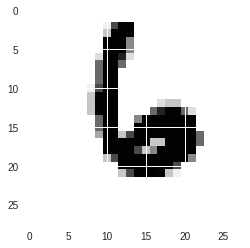

In [0]:
plt.imshow(x_train[12].squeeze())

#### convert the data to the right type

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (41580, 28, 28, 1)
41580 train samples
420 test samples


### convert class vectors to binary class matrices - this is for use in the
### categorical_crossentropy loss below

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Creating the Model with Keras


In [0]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,kernel_size=(6,6),strides=(1,1),
                        padding="same", 
                        activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same'))
model.add(layers.Conv2D(filters=64,kernel_size=(6,6),strides=(1,1),
                        padding="same", activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024,activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=10,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              3212288   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])

In [0]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test))

In [0]:
H.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

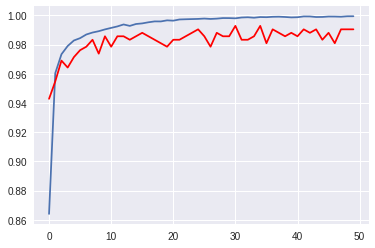

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'],'r')

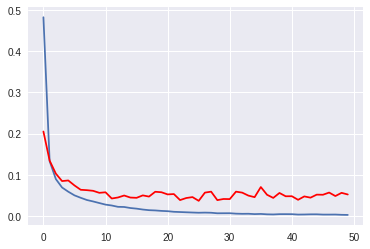

In [0]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'],'r')

## Predict

In [0]:
unlabeled_images_test = pd.read_csv('gdrive/My Drive/dataML/test.csv')
#unlabeled_images_test = pd.read_csv('test.csv')

In [0]:
X_unlabeled = unlabeled_images_test.values.reshape(unlabeled_images_test.shape[0],28,28,1)/255

In [0]:
y_pred = model.predict(X_unlabeled)

In [0]:
y_label = np.argmax(y_pred, axis=1)

## Save csv

In [0]:
imageId = np.arange(1,y_label.shape[0]+1).tolist()
prediction_pd = pd.DataFrame({'ImageId':imageId, 'Label':y_label})
prediction_pd.to_csv('gdrive/My Drive/dataML/out_cnn3.csv',sep = ',', index = False)

NameError: ignored

# Tensorflow

### Helper functions for batch learning

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = train_images.as_matrix()
        train_len = self.training_images.shape[0]
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,28,28,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(train_labels.as_matrix().reshape(-1), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = test_images.as_matrix()
        test_len = self.test_images.shape[0]
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,28,28,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(test_labels.as_matrix().reshape(-1), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [0]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model



** Create 2 placeholders, x and y_true. Their shapes should be: **

* x shape = [None,28,28,1]
* y_true shape = [None,10]

** Create one more placeholder called hold_rate. No need for shape here. This placeholder will just hold a single probability for the dropout. **

In [0]:
x = tf.placeholder(tf.float32, shape=[None,28,28,1])
y_true = tf.placeholder(tf.float32, shape=[None,10])
hold_rate = tf.placeholder(tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# x -->[batch, in_height, in_width, in_channels]
# W --> [filter_height, filter_width, in_channels, out_channels]

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Create the Layers



In [0]:
convo_1 = convolutional_layer(x,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [0]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [0]:
full_one_dropout = tf.nn.dropout(full_layer_one,rate=hold_rate)

In [0]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [0]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels = y_true, logits = y_pred)

### Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.00002)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [0]:
init = tf.global_variables_initializer()

### Saving the Model

In [0]:
saver = tf.train.Saver()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [0]:
history = {'acc_train':list(),'acc_val':list(),
           'loss_train':list(),'loss_val':list()}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(10000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_rate: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            feed_dict_train = {x: batch[0], y_true: batch[1], hold_rate:0}
            feed_dict_val = {x:ch.test_images, y_true:ch.test_labels, hold_rate:0}

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            history['acc_train'].append(sess.run(acc, feed_dict = feed_dict_train))
            history['acc_val'].append(sess.run(acc, feed_dict = feed_dict_val))

            history['loss_train'].append(sess.run(cross_entropy, feed_dict = feed_dict_train))
            history['loss_val'].append(sess.run(cross_entropy, feed_dict = feed_dict_val))
            
            print("Iteration {}:\tloss_train={:.6f}:\tloss_val={:.6f}:\tacc_train={:.6f}:\tacc_val={:.6f}"
                  .format(i,history['loss_train'][-1],history['loss_val'][-1],history['acc_train'][-1],history['acc_val'][-1]))
            
            print('\n')
        
    saver.save(sess,'models_saving/my_model.ckpt')

Iteration 0:	loss_train=9.955038:	loss_val=9.892747:	acc_train=0.080000:	acc_val=0.064286


Iteration 100:	loss_train=1.393851:	loss_val=1.341649:	acc_train=0.570000:	acc_val=0.573810


Iteration 200:	loss_train=0.603045:	loss_val=0.658347:	acc_train=0.780000:	acc_val=0.788095


Iteration 300:	loss_train=0.351420:	loss_val=0.452447:	acc_train=0.870000:	acc_val=0.840476


Iteration 400:	loss_train=0.315513:	loss_val=0.356125:	acc_train=0.890000:	acc_val=0.869048


Iteration 500:	loss_train=0.456678:	loss_val=0.303237:	acc_train=0.840000:	acc_val=0.900000


Iteration 600:	loss_train=0.365461:	loss_val=0.264532:	acc_train=0.880000:	acc_val=0.928571


Iteration 700:	loss_train=0.240603:	loss_val=0.237371:	acc_train=0.920000:	acc_val=0.938095


Iteration 800:	loss_train=0.259049:	loss_val=0.220457:	acc_train=0.910000:	acc_val=0.938095


Iteration 900:	loss_train=0.167229:	loss_val=0.207158:	acc_train=0.930000:	acc_val=0.945238


Iteration 1000:	loss_train=0.244950:	loss_val=0.196606:	acc_tr

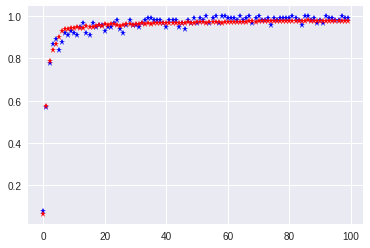

In [0]:
plt.plot(history['acc_train'],'b*')
plt.plot(history['acc_val'],'r*')

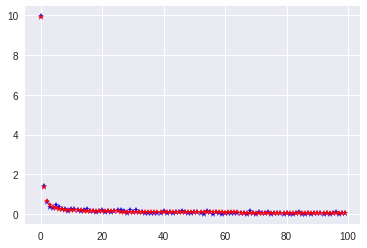

In [0]:
plt.plot(history['loss_train'],'b*')
plt.plot(history['loss_val'],'r*')

### Loading a Model

In [0]:
with tf.Session() as sess:
    
    # Restore the model
    saver.restore(sess, 'models_saving/my_model.ckpt')
    

    # Fetch Back Results
    label = sess.run(y_pred, feed_dict={x:X_unlabeled,hold_prob:1.0})

INFO:tensorflow:Restoring parameters from models_saving/my_model.ckpt


In [0]:
label.shape

(28000, 10)

In [0]:
label = np.argmax(label, axis=1 )

In [0]:
label.shape

(28000,)

### Predict

In [0]:
unlabeled_images_test = pd.read_csv('gdrive/My Drive/dataML/test.csv')
#unlabeled_images_test = pd.read_csv('test.csv')

In [0]:
X_unlabeled = unlabeled_images_test.values.reshape(unlabeled_images_test.shape[0],28,28,1)/255

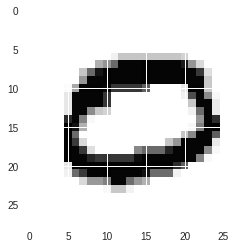

In [0]:
plt.imshow(X_unlabeled[1].reshape(28,28))

In [0]:
X_unlabeled.shape

(28000, 28, 28, 1)

## Predict the unlabeled test sets using the model

In [0]:
imageId = np.arange(1,label.shape[0]+1).tolist()

In [0]:
prediction_pd = pd.DataFrame({'ImageId':imageId, 'Label':label})

In [0]:
prediction_pd.to_csv('out_cnn4.csv',sep = ',', index = False)